In [2]:
import numpy as np
import os

In [3]:
#plotting
from sig_outline import *
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set(color_codes = True)
def plot_time_freq(dat,
                   rel_start=-1200,
                   rel_stop=400,
                   _ax=None,
                   verbose=False,
                   **kws):
    """Make time-freq plot and return ax."""
    # User-defined params.
    figsize = kws.get('figsize', (4, 2))
    dpi = kws.get('dpi', 1200)
    font = kws.get('font', {'tick': 7, 'annot': 10, 'label': 8, 'fig': 10})
    spine_len = kws.get('spine_len', 2)
    spine_lw = kws.get('spine_lw', 0.5)
    cmap = kws.get('cmap', 'RdBu_r')
    tickpad = kws.get('tickpad', 2)
    labelpad = kws.get('labelpad', 4)
    xtick_step = kws.get('xtick_step', 200) # ms
    t0_lw = kws.get('t0_lw', 1.5)
    freqs = kws.get('freqs', np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)]))
    yticks = kws.get('yticks', np.arange(len(freqs))[::4] + 0.5)
    yticklabels = kws.get('yticklabels', freqs[::4].astype(int))
    cbar_label = kws.get('cbar_label', '$t$-value')
    title = kws.get('title', None)
    subj = kws.get('subj', None)
    # --------------
    # Make the plot.
    if _ax is None:
        plt.close()
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = np.ravel(ax)
        iax = 0
        _ax = ax[iax]
    # Calculate param values.
    dur_ms = rel_stop - rel_start
    n_samp = dat.shape[1]
    t0 = np.round(n_samp * (-rel_start / dur_ms), 0).astype(int) # vocalization onset (samples)
    n_ticks = int((rel_stop - rel_start) / xtick_step) + 1
    xticks = np.linspace(0, n_samp, n_ticks).astype(int)
    xticklabels = np.linspace(rel_start, rel_stop, n_ticks).astype(int)
    vmax = 3
    vmin = -3
#     vmax = kws.get('vmin', np.max(np.abs(dat)))
#     vmin = kws.get('vmax', -vmax)
    vticks = kws.get('vticks', np.round(np.linspace(np.ceil(vmin), np.floor(vmax), 5), 1))
    if verbose:
        print('vmin: {}, vmax: {}'.format(vmin, vmax))
    _ax = sns.heatmap(data=dat,  ax=_ax, cmap=cmap, vmin=vmin, vmax=vmax)
    _ax.invert_yaxis()
    ymin, ymax = _ax.get_ylim()
    _ax.vlines(x=t0, ymin=ymin, ymax=ymax, color='k', lw=t0_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len,
                    width=spine_lw, rotation=0, color='k')
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabels)
    _ax.set_xlabel('Time (ms)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabels)
    _ax.set_ylabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
    cbar = _ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    cbar.set_ticks(vticks)
    cbar.set_ticklabels(vticks)
    cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)
    if title:
        _ax.set_title(title, fontsize=font['fig'])
    if subj:
        _ax.annotate(subj, (-0.05, 1.05), xycoords='axes fraction', fontsize=font['annot'])
    return _ax

/usr/global/Anaconda/2019-10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


modules imported


In [4]:
import cmlreaders as cml
import scipy.stats as stats
import pandas as pd
dpi = 600
freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
rel_start = 450
rel_stop = 750
wave_number = 5
half_wav = ((1000 / freqs.min()) * wave_number) * 0.5
index = cml.get_data_index('r1')
index = index[index == 'RepFR1']
dat_check = False
# path = '/scratch/radrogue/RepFR1/'
# print('processed regions:')
# for file in os.listdir(path):
#     d = os.path.join(path, file)
#     if os.path.isdir(d):
#         words = d.split('/')[-1].split('_')
#         print(words[0] + ' ' + words[1])

In [5]:
hemisphere = 'Left'
region = 'frontal gyrus'

path = '/scratch/radrogue/RepFR1/{}/'.format(hemisphere+'_'+region)
for root, dirs, files in os.walk(path):
    if root == path:
        subs = dirs
        break


## Binned and Averaged Time Course SME

In [11]:
condition = 'first'
# subs = results[results.region == hemisphere+' '+region].subjects.iloc[0]
# *** Use this to test a single subject *** #
# subs =['R1589T']
for subj in subs:
#     try:
    data = cml.get_data_index('r1')
    data = data[data['experiment'] == 'RepFR1']
    data = data[data.subject==subj]
    r = cml.CMLReader(subject=subj, experiment='RepFR1', session=data.session.iloc[0])
    eeg = r.load('eeg')
    sr = float(eeg.samplerate)
    buffer_ms = (wave_number * (1000/freqs[0])) / 2
    buffer_samp = int(np.ceil(buffer_ms * (sr/1000.)))
    buffer_minimized = buffer_ms/1000
    path = '/scratch/radrogue/RepFR1/{}/{}/matched_delib/'.format(hemisphere+'_'+region, subj)
    file_name = '{}_{}_sme_tscore.npy'.format(subj, condition)
    powers = np.load(path+file_name)
    num_elec = powers.shape[0]
    dat = np.mean(powers,0)
    if np.isnan(dat).all():
        print(subj, hemisphere, region, 'tstat failed')
        raise Exception

    binned_mean = []
    # *** Bins data by 100 ms at 20 ms intervals and takes the mean
    for t in np.arange(0, dat.shape[-1] - 100*(sr/1000), 20*(sr/1000)):
        binned = dat[:, int(round(t)):int(round(t+100*(sr/1000)))]
        binned_mean.append(np.mean(binned, -1))

    binned_mean= np.asarray(binned_mean).T
    binned_mean[(binned_mean<1.5) & (binned_mean>-1.5)] =0.0

    # *** Limit to rel_start and stop 
    # dat = dat[:, int(rel_start*(sr / 1000)):int(rel_stop*(sr / 1000))]


    # avg_dat = np.mean(dat, -1).reshape(24,1)

    plot_time_freq(binned_mean, rel_start = 0, rel_stop = 1600, freqs = freqs)#,
    #               _ax = _ax, title = "vocalization time-course")
    plt.title(subj + ' (' + str(num_elec)+ ' electrodes)')
    folder = hemisphere[0]+'_'+region[0:4]+'_'+condition+'_'+'presentation'
    if not os.path.exists(folder):
        os.mkdir(folder)
    plt.savefig(folder+'/'+subj+'.pdf', bbox_inches = 'tight')
#         plt.show()
    break

#     except Exception as e:
#         print(subj, 'no data')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/radrogue/RepFR1/Left_frontal gyrus/R1501J/matched_delib/R1501J_first_sme_tscore.npy'

In [28]:
import cmlreaders as cml
import scipy.stats as stats
import pandas as pd
dpi = 600
freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
rel_start = 450
rel_stop = 750
wave_number = 5
half_wav = ((1000 / freqs.min()) * wave_number) * 0.5
dat_check = False
all_binned = []
all_dat = []
from tqdm import tqdm_notebook as timer
for subj in timer(subs):
    try:
        path = '/scratch/radrogue/RepFR1/{}/{}/sme_pow_debug/'.format(hemisphere+'_'+region,subj)
        file_name = '{}_{}_sme_tscore.npy'#.format(subj, "first")
        powers = np.load(path+file_name.format(subj, "first"))
#         powers = np.load(path+file_name)
        sr = powers.shape[-1]/1.599
        num_elec = powers.shape[0]
        dat = np.mean(powers,0)
        if np.isnan(dat).all():
            print(subj, hemisphere, region, 'tstat failed')
            raise Exception
        # *** Limit to rel_start and stop 
        # dat = dat[:, int(rel_start*(sr / 1000)):int(rel_stop*(sr / 1000))]
        all_dat.append(dat)
        binned_mean = []
        count = 0
        # *** Bins data by 100 ms at 20 ms intervals and takes the mean
        for t in np.arange(0, dat.shape[-1] - 100*(sr/1000), 20*(sr/1000)):
            if count < 75:
                binned = dat[:, int(round(t)):int(round(t+100*(sr/1000)))]
                binned_mean.append(np.mean(binned, -1))
                count+=1

        binned_mean= np.asarray(binned_mean).T



        all_binned.append(binned_mean)
        
    except Exception as e:
        print(subj, 'no data')
        

R1566D no data



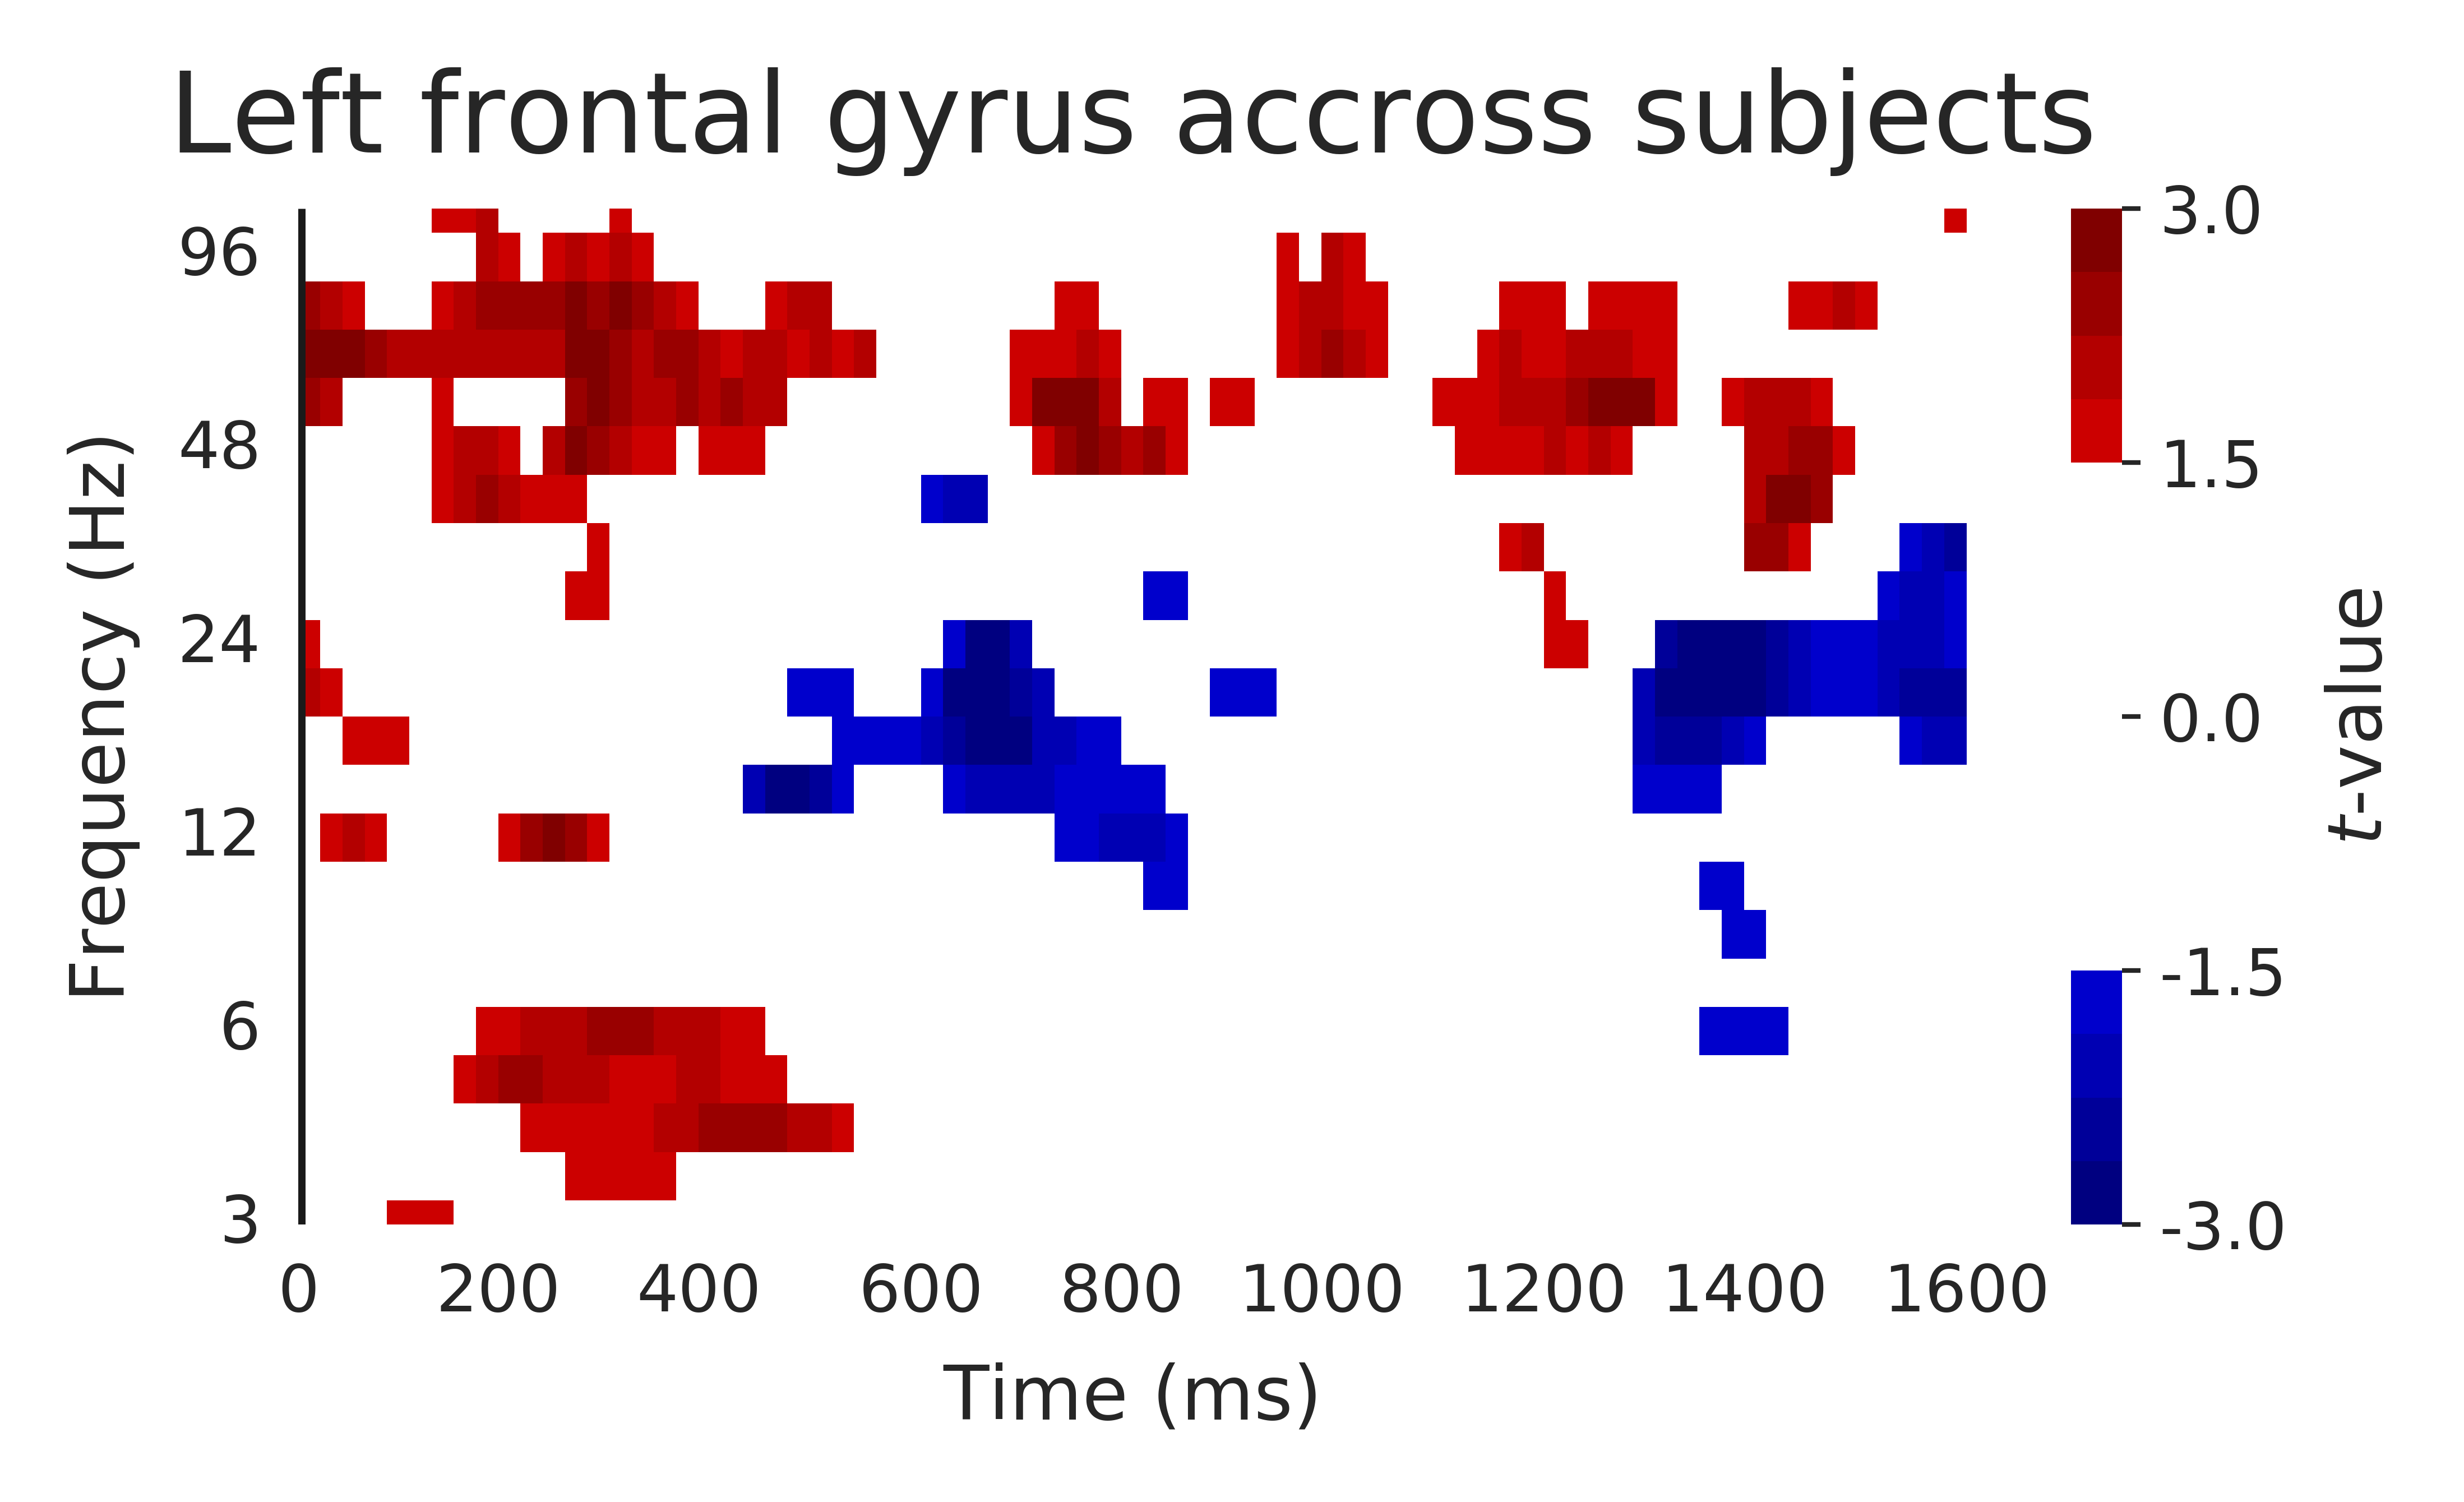

In [29]:
array_binned = np.asarray(all_binned)
# np.where(np.isnan(array_binned))
ttest = stats.ttest_1samp(array_binned, popmean = 0, axis = 0).statistic
# print(ttest)
# ttest[(ttest<1.5) & (ttest>-1.5)] =0.0
from matplotlib.colors import LinearSegmentedColormap


myColors = ((0.0, 0.0, 0.6, 1.0),(0.0, 0.0, 0.8, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.8, 0.0, 0.0, 1.0),(0.6, 0.0, 0.0, 1.0))
two_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
myColors = ((0.0, 0.0, 0.5, 1.0),(0.0, 0.0, 0.6, 1.0),(0.0, 0.0, 0.7, 1.0), (0.0, 0.0, 0.8, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.8, 0.0, 0.0, 1.0),(0.7, 0.0, 0.0, 1.0),(0.6, 0.0, 0.0, 1.0),(0.5, 0.0, 0.0, 1.0))
point_five_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

plot_time_freq(ttest, rel_start = 0, rel_stop = 1600, freqs = freqs, cmap=point_five_cmap)
plt.title(hemisphere+' ' + region + ' accross subjects')
plt.savefig(folder + '/between_subj.pdf', bbox_inches = 'tight')

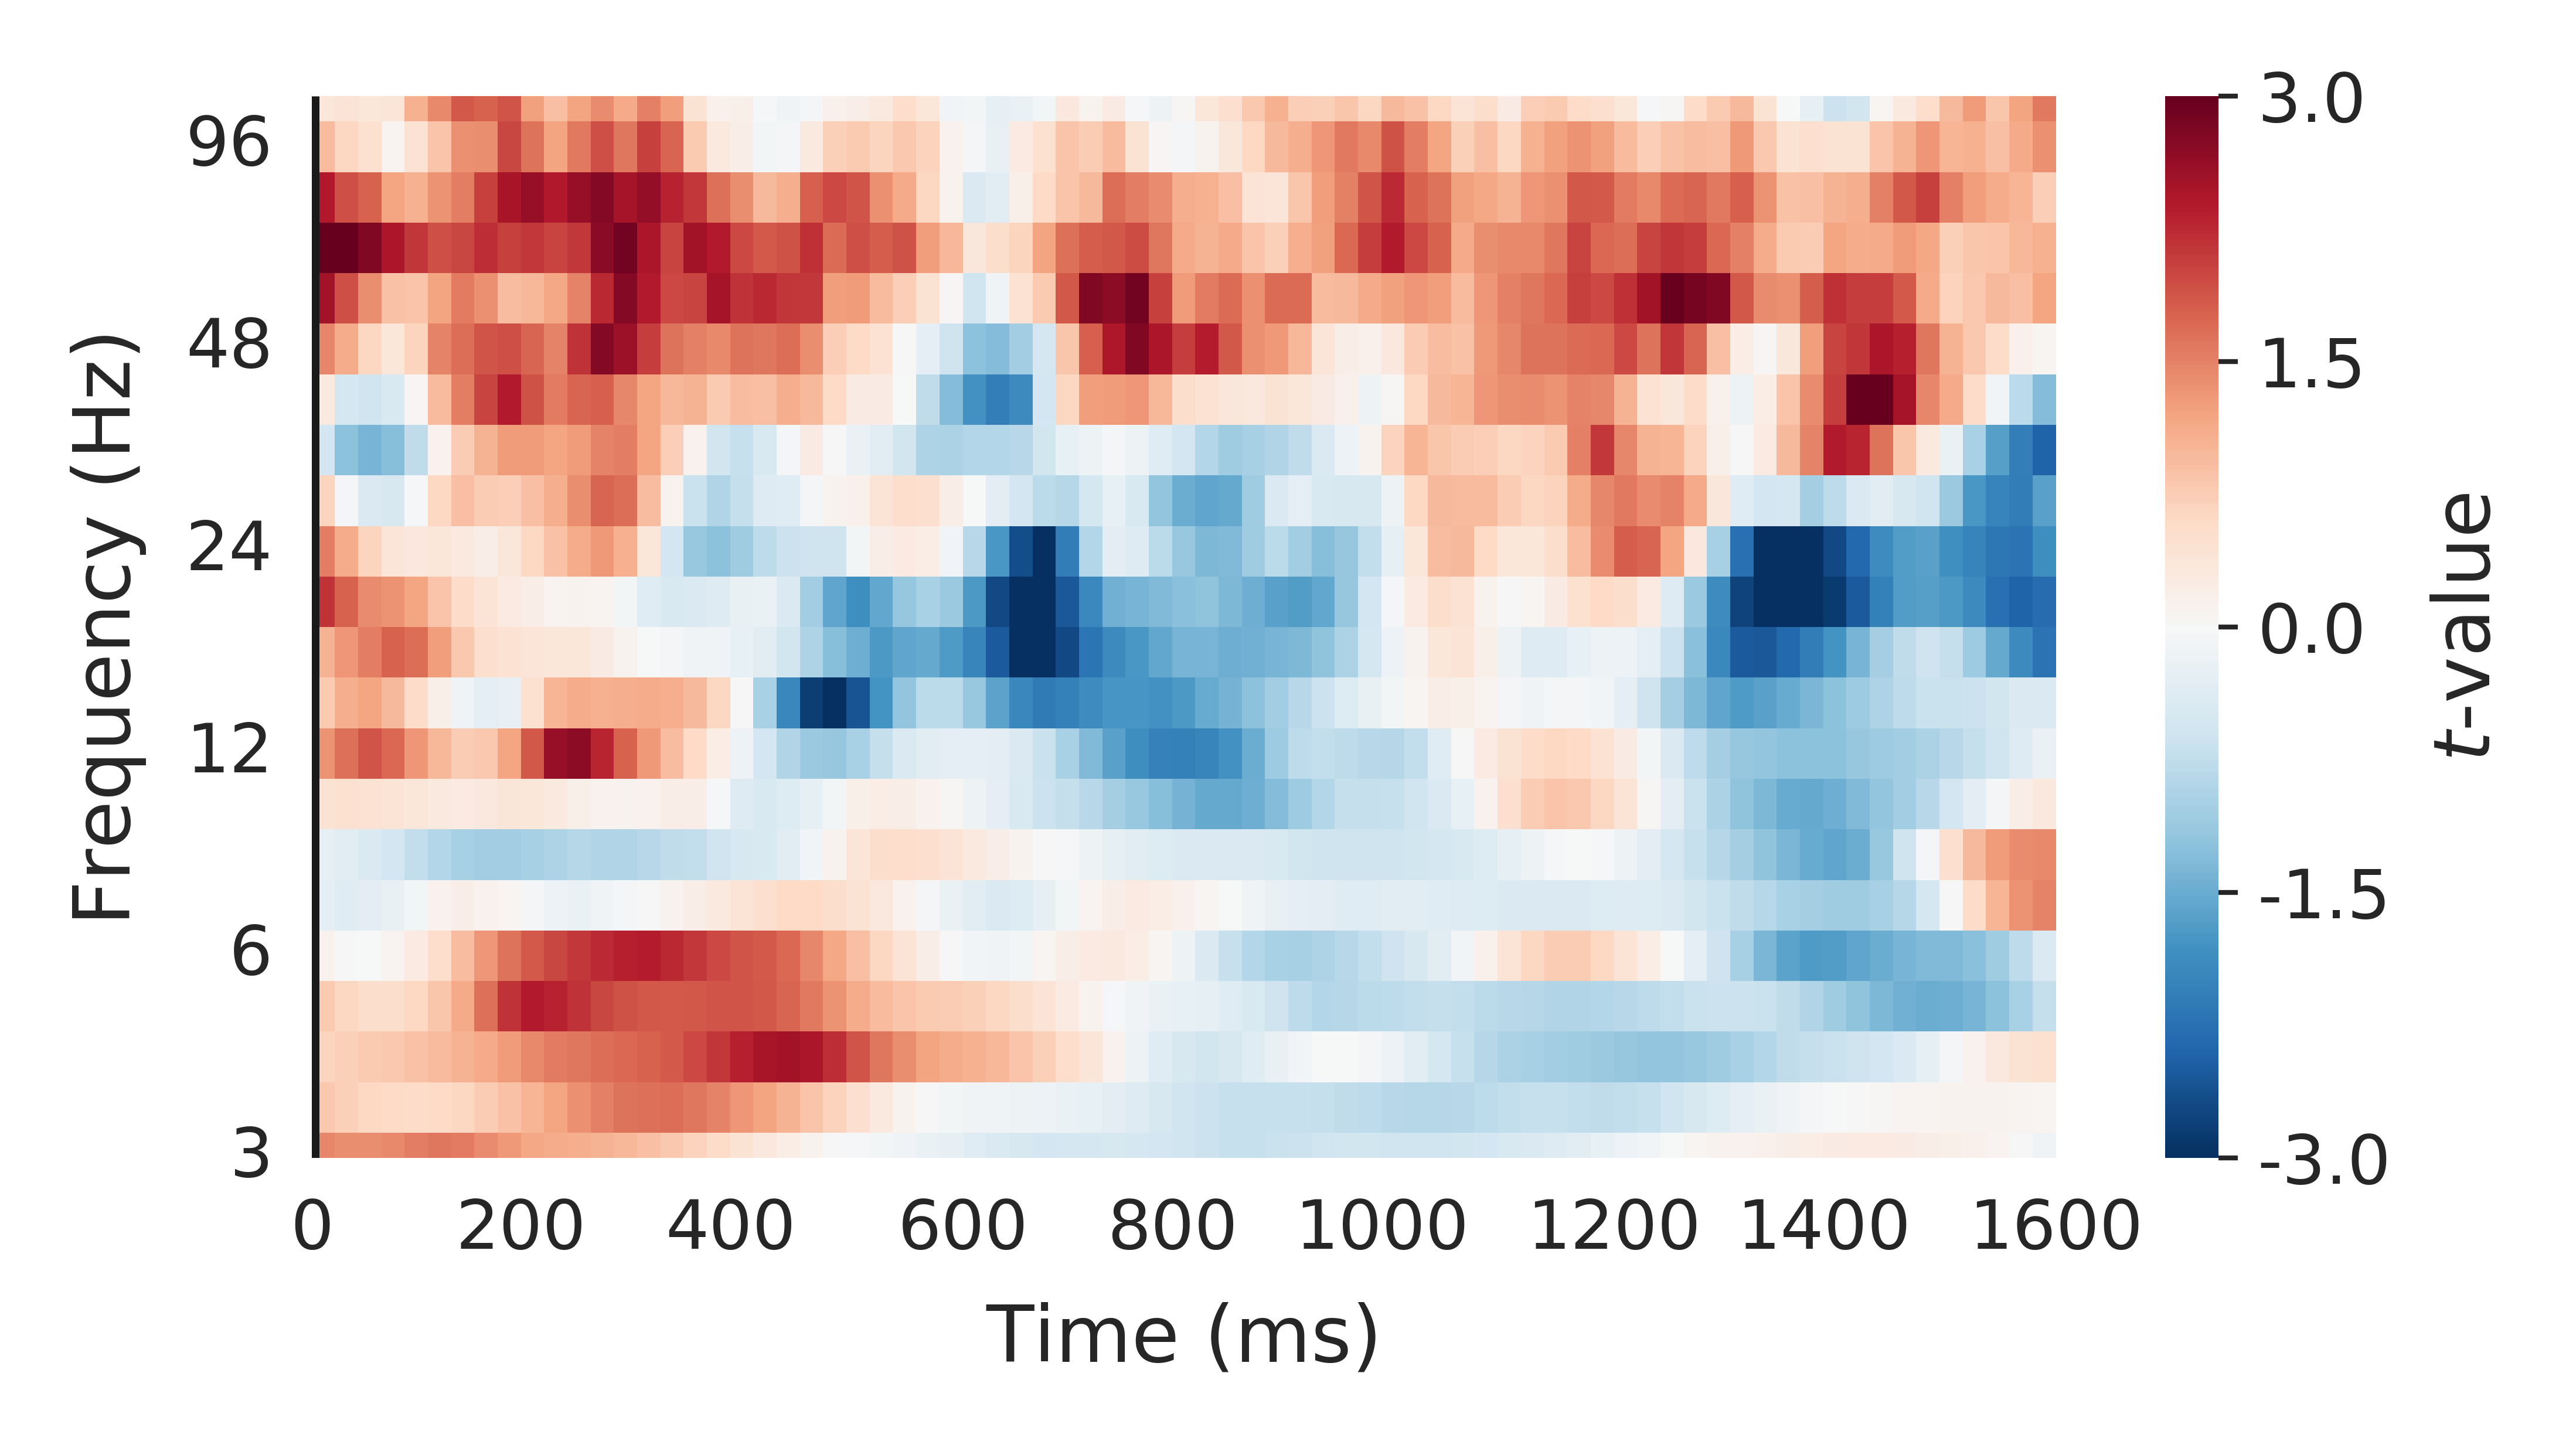

In [30]:
plot_time_freq(ttest, rel_start = 0, rel_stop = 1600, freqs = freqs)

## By Region

R1589T Left Left_MTG tstat failed
Left_MTG R1589T no data
Left_MTG R1566D no data
Right_MTG R1566D no data
R1589T Left Right_MTG tstat failed
Right_MTG R1589T no data
Right_MTG R1604J no data
Left_frontal gyrus R1566D no data
R1589T Left Right_frontal gyrus tstat failed
Right_frontal gyrus R1589T no data
R1589T Left Left_Hippocampus tstat failed
Left_Hippocampus R1589T no data
Left_Hippocampus R1566D no data
Right_Hippocampus R1566D no data
R1589T Left Left_MTL tstat failed
Left_MTL R1589T no data
Left_MTL R1566D no data
Right_MTL R1566D no data


/home1/radrogue/RepFR_iEEG/sig_outline.py:73: UserWarning: No contour levels were found within the data range.
  extent=[0-0.5, x[:-1].max()-0.5,0-0.5, y[:-1].max()-0.5])


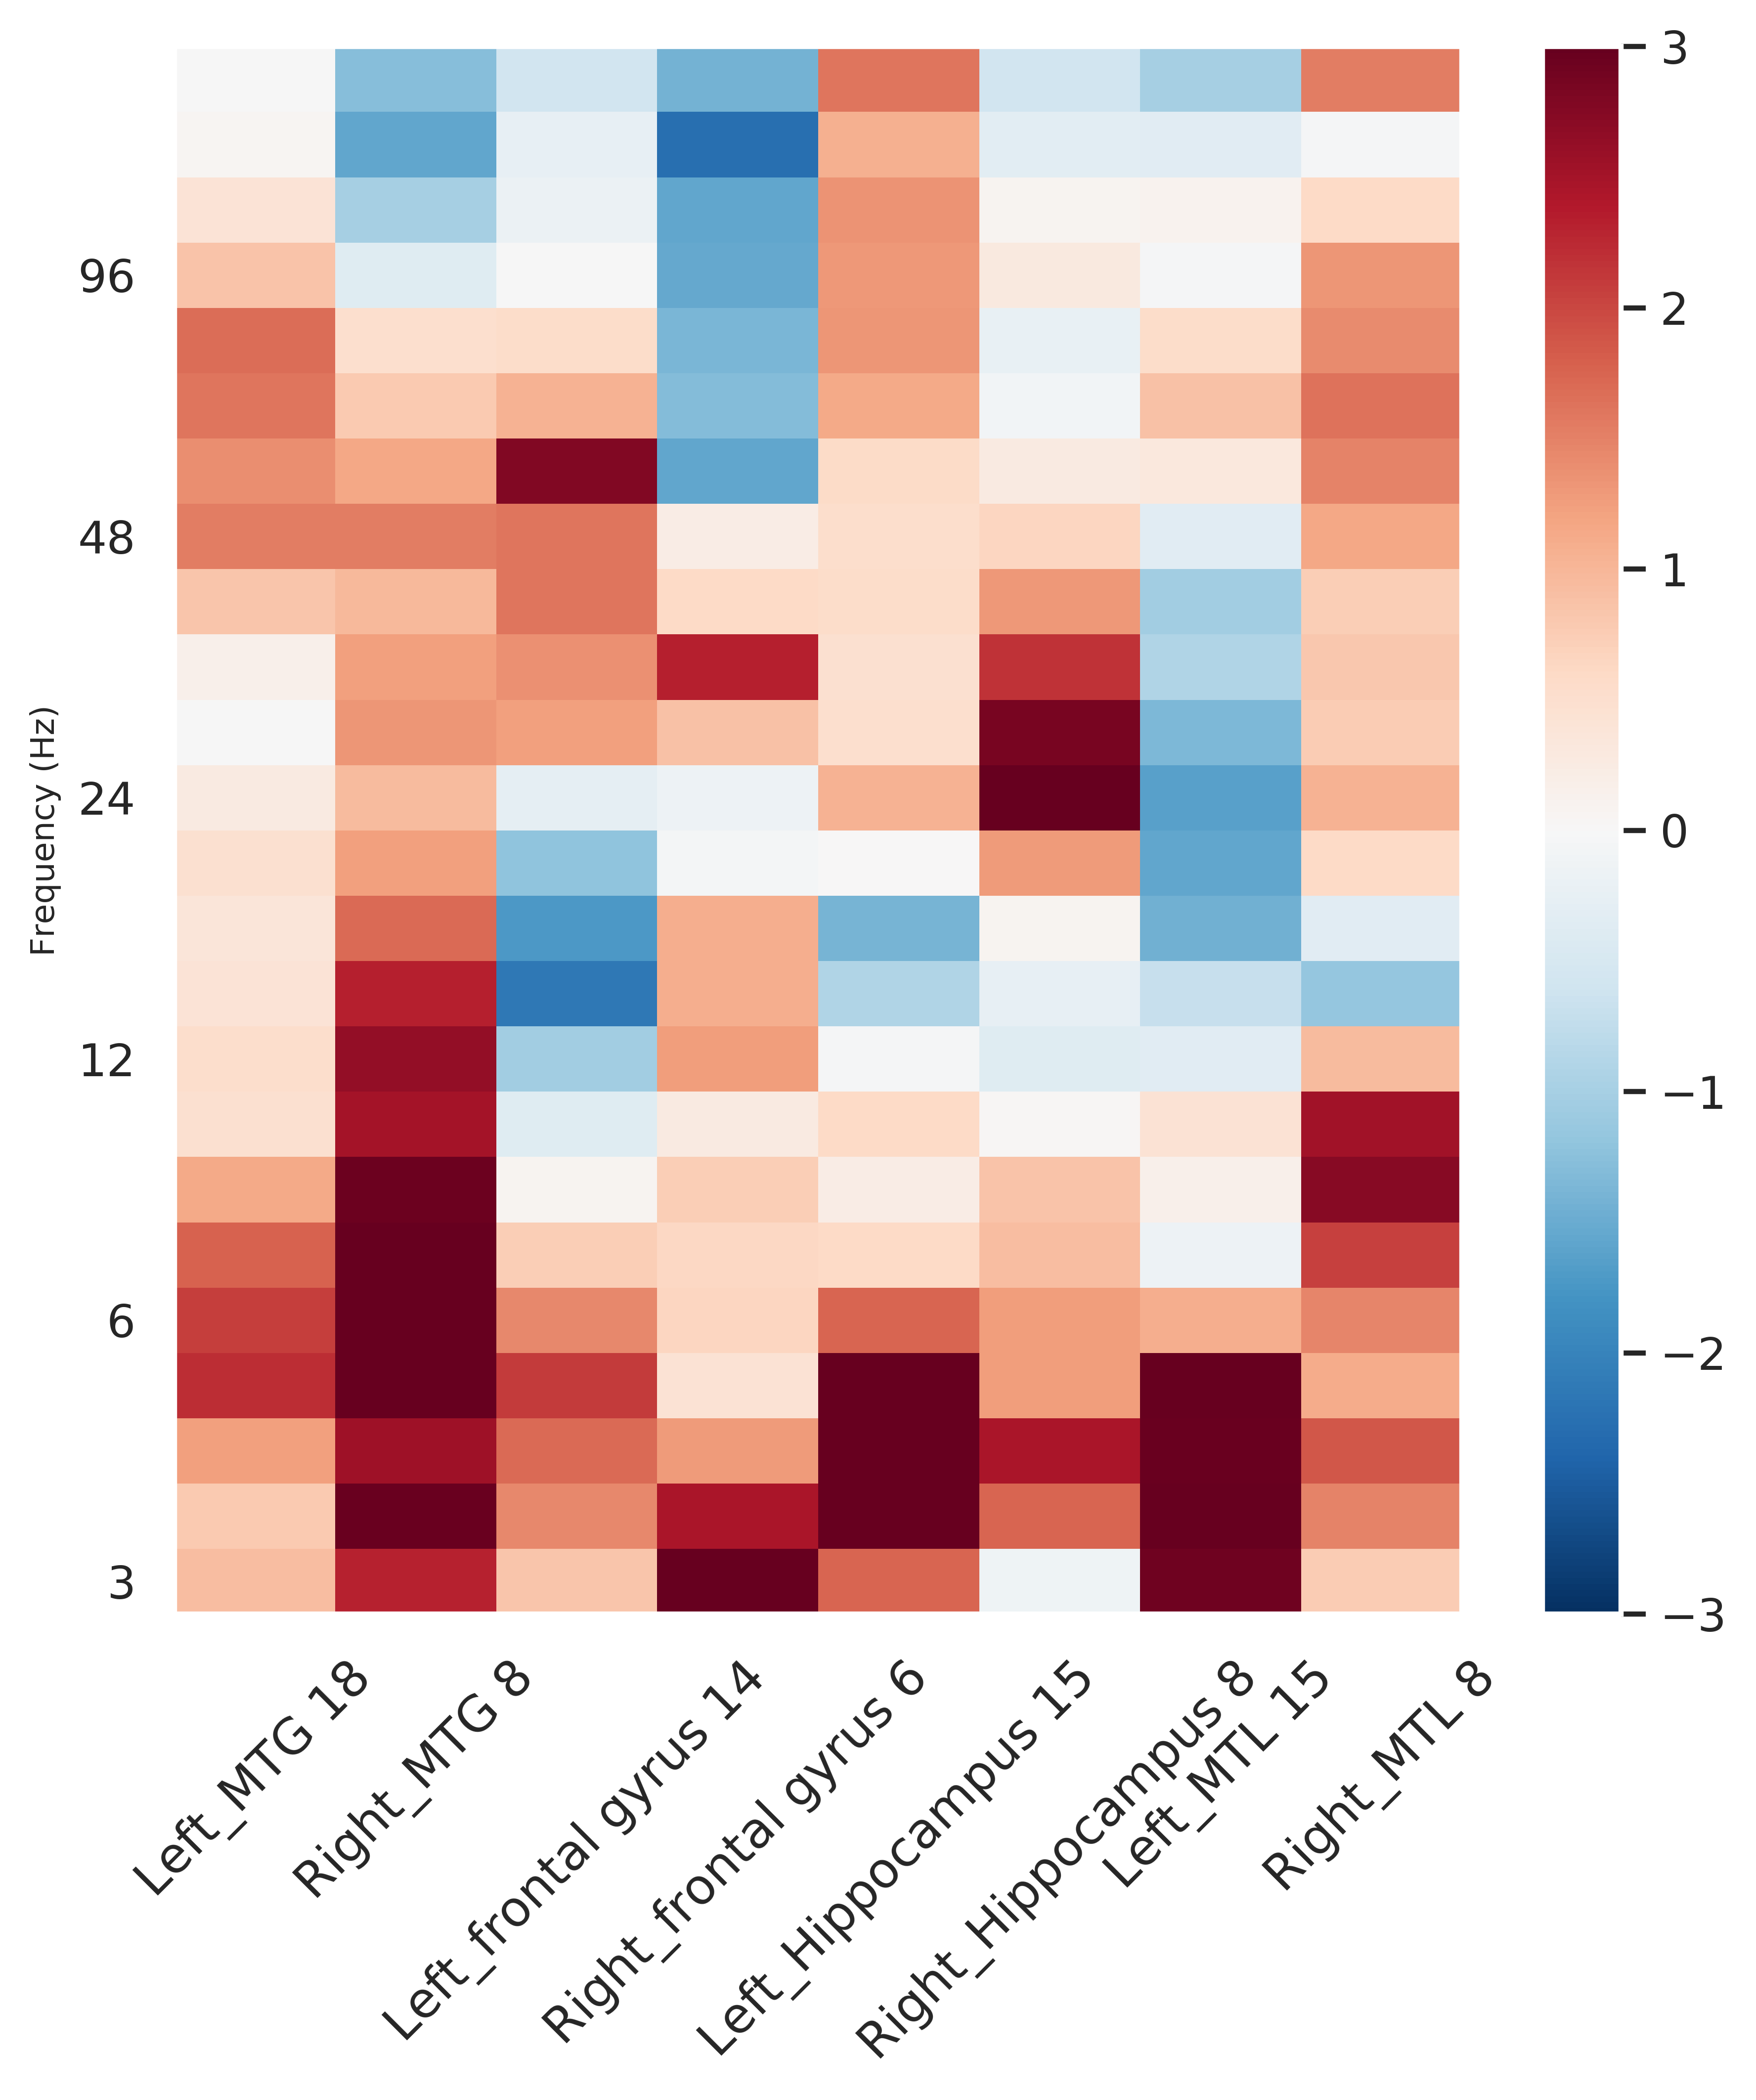

In [10]:
import cmlreaders as cml
import scipy.stats as stats
import pandas as pd
from sig_outline import *
dpi = 600
freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
rel_start = 450
rel_stop = 750
wave_number = 5
half_wav = ((1000 / freqs.min()) * wave_number) * 0.5
index = cml.get_data_index('r1')
index = index[index == 'RepFR1']
dat_check = False
cmap = 'RdBu_r'

freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
best_regions = ['Left_MTG', 'Right_MTG', 'Left_frontal gyrus', 'Right_frontal gyrus',
                'Left_Hippocampus','Right_Hippocampus', 'Left_MTL', 'Right_MTL']
                 
l_regions = ['Left_temporal',  'Left_frontal', 'Left_Hippocampus',
            'Left_MTG', 'Left_parahippocampal',  
          'Left_entorhinal',  'Left_Amygdala', 'Left_orbital']
r_regions = ['Right_temporal', 'Right_frontal', 'Right_Hippocampus', 
             'Right_parahippocampal', 'Right_MTG', 'Right_entorhinal', 
             'Right_Amygdala', 'Right_orbital']
all_dat = []
all_pvals = []
num_subs = []
for r in best_regions:
    region_dat = []
    subs = []
    big_path = '/scratch/radrogue/RepFR1/{}/'.format(r)
    for file in os.listdir(big_path):
        d = os.path.join(big_path, file)
        if os.path.isdir(d):
            subs.append(d.split('/')[-1])
    count = 0
    for subj in subs:
        try:
            path = '/scratch/radrogue/RepFR1/{}/{}/matched_delib/'.format(r,subj)
            file_name = '{}_delib_imrec_t_pows_NO_A.npy'
            powers = np.load(path+file_name.format(subj))
            num_elec = powers.shape[0]
            dat = np.mean(powers, -1)
#             print(dat.shape)
            if np.isnan(dat).all():
                print(subj, hemisphere, r, 'tstat failed')
                raise Exception
            region_dat.append(dat)
            count += 1
        except:
            print(r + ' ' + subj + ' no data')  
    num_subs.append(count)
            # *** Limit to rel_start and stop 
            # dat = dat[:, int(rel_start*(sr / 1000)):int(rel_stop*(sr / 1000))]
            
#         except Exception as e:
#             print(subj, 'no data')
    
    mean_dat = []
    for i in region_dat:
        mean_dat.append(np.mean(i, 0))
    mean_dat = np.asarray(mean_dat)
    ttest, pval = stats.ttest_1samp(mean_dat, popmean = 0, axis = 0)
    all_pvals.append(pval.reshape(24,1))
    all_dat.append(ttest.reshape(24,1))
all_dat = np.asarray(all_dat)[:,:,0].T
all_pvals = np.asarray(all_pvals)[:,:,0].T
for i, num_sub in enumerate(num_subs):
    best_regions[i] = best_regions[i] + ' ' + str(num_sub)

from matplotlib.colors import LinearSegmentedColormap
figsize = [6, 4]
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
vmin = -3
vmax = +3

# plt.yticks(locs, label = str(freqs))
myColors = ((0.0, 0.0, 0.6, 1.0),(0.0, 0.0, 0.8, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.8, 0.0, 0.0, 1.0),(0.6, 0.0, 0.0, 1.0))
two_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

myColors = ((0.0, 0.0, 0.5, 1.0),(0.0, 0.0, 0.6, 1.0),(0.0, 0.0, 0.7, 1.0), (0.0, 0.0, 0.8, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.8, 0.0, 0.0, 1.0),(0.7, 0.0, 0.0, 1.0),(0.6, 0.0, 0.0, 1.0),(0.5, 0.0, 0.0, 1.0))
point_five_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
analysis = 'matched_delib'
fdr_heatmap(tvals = all_dat, pvals = all_pvals, figsize = (7,7), cmap=cmap, vmin=vmin, vmax=vmax, 
            title = analysis.title(), analysis=analysis, x_label='Regions', y_labels='Frequencies', freqs=freqs,  
            _ax = _ax, best_regions=best_regions)
#     sns.heatmap(data= all_dat, cmap=cmap, vmin=vmin, vmax=vmax, ax=_ax)
#     sns.set(rc = {'figure.figsize':(4,4)})
_ax.invert_yaxis()
locs, labels = plt.yticks()
_ = _ax.set_yticks(locs)
_ = _ax.set_yticklabels(freqs[1::2].astype(int), fontsize = 7, rotation=0)
_ = _ax.set_xticklabels(best_regions, fontsize = 6, rotation = 45)
_ = _ax.set_ylabel('Frequencies')
plt.savefig('{}.pdf'.format(analysis), bbox_inches='tight')



In [10]:
import cmlreaders as cml
import scipy.stats as stats
import pandas as pd

dpi = 600
freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
rel_start = 450
rel_stop = 750
wave_number = 5
half_wav = ((1000 / freqs.min()) * wave_number) * 0.5
index = cml.get_data_index('r1')
index = index[index == 'RepFR1']
dat_check = False
cmap = 'RdBu_r'

freqs = np.array([2**(np.log2(3) + (iFreq/4)) for iFreq in range(24)])
best_regions = ['Left_MTG', 'Right_MTG', 'Left_frontal gyrus', 'Right_frontal gyrus',
                'Left_Hippocampus','Right_Hippocampus', 'Left_MTL', 'Right_MTL']
                 
l_regions = ['Left_temporal',  'Left_frontal', 'Left_Hippocampus',
            'Left_MTG', 'Left_parahippocampal',  
          'Left_entorhinal',  'Left_Amygdala', 'Left_orbital']
r_regions = ['Right_temporal', 'Right_frontal', 'Right_Hippocampus', 
             'Right_parahippocampal', 'Right_MTG', 'Right_entorhinal', 
             'Right_Amygdala', 'Right_orbital']
all_dat = []
num_subs = []
for r in best_regions:
    region_dat = []
    subs = []
    big_path = '/scratch/radrogue/RepFR1/{}/'.format(r)
    for file in os.listdir(big_path):
        d = os.path.join(big_path, file)
        if os.path.isdir(d):
            subs.append(d.split('/')[-1])
    count = 0
    for subj in subs:
        try:
            path = '/scratch/radrogue/RepFR1/{}/{}/matched_delib/'.format(r,subj)
            file_name = '{}_delib_imrec_t_pows_NO_A.npy'
            powers = np.load(path+file_name.format(subj))
            num_elec = powers.shape[0]
            dat = np.mean(powers, -1)
#             print(dat.shape)
            if np.isnan(dat).all():
                print(subj, hemisphere, r, 'tstat failed')
                raise Exception
            region_dat.append(dat)
            count += 1
        except:
            print(r + ' ' + subj + ' no data')  
    num_subs.append(count)
            # *** Limit to rel_start and stop 
            # dat = dat[:, int(rel_start*(sr / 1000)):int(rel_stop*(sr / 1000))]
            
#         except Exception as e:
#             print(subj, 'no data')
    
    mean_dat = []
    for i in region_dat:
        mean_dat.append(np.mean(i, 0))
    mean_dat = np.asarray(mean_dat)
    ttest = stats.ttest_1samp(mean_dat, popmean = 0, axis = 0).statistic.reshape(24,1)
    all_dat.append(ttest)
all_dat = np.asarray(all_dat)[:,:,0].T
for i, num_sub in enumerate(num_subs):
    best_regions[i] = best_regions[i] + ' ' + str(num_sub)

R1589T Left Left_MTG tstat failed
Left_MTG R1589T no data
Left_MTG R1566D no data
Right_MTG R1566D no data
R1589T Left Right_MTG tstat failed
Right_MTG R1589T no data
Left_frontal gyrus R1566D no data
R1589T Left Right_frontal gyrus tstat failed
Right_frontal gyrus R1589T no data
R1589T Left Left_Hippocampus tstat failed
Left_Hippocampus R1589T no data
Left_Hippocampus R1566D no data
Right_Hippocampus R1566D no data
R1589T Left Left_MTL tstat failed
Left_MTL R1589T no data
Left_MTL R1566D no data
Right_MTL R1566D no data


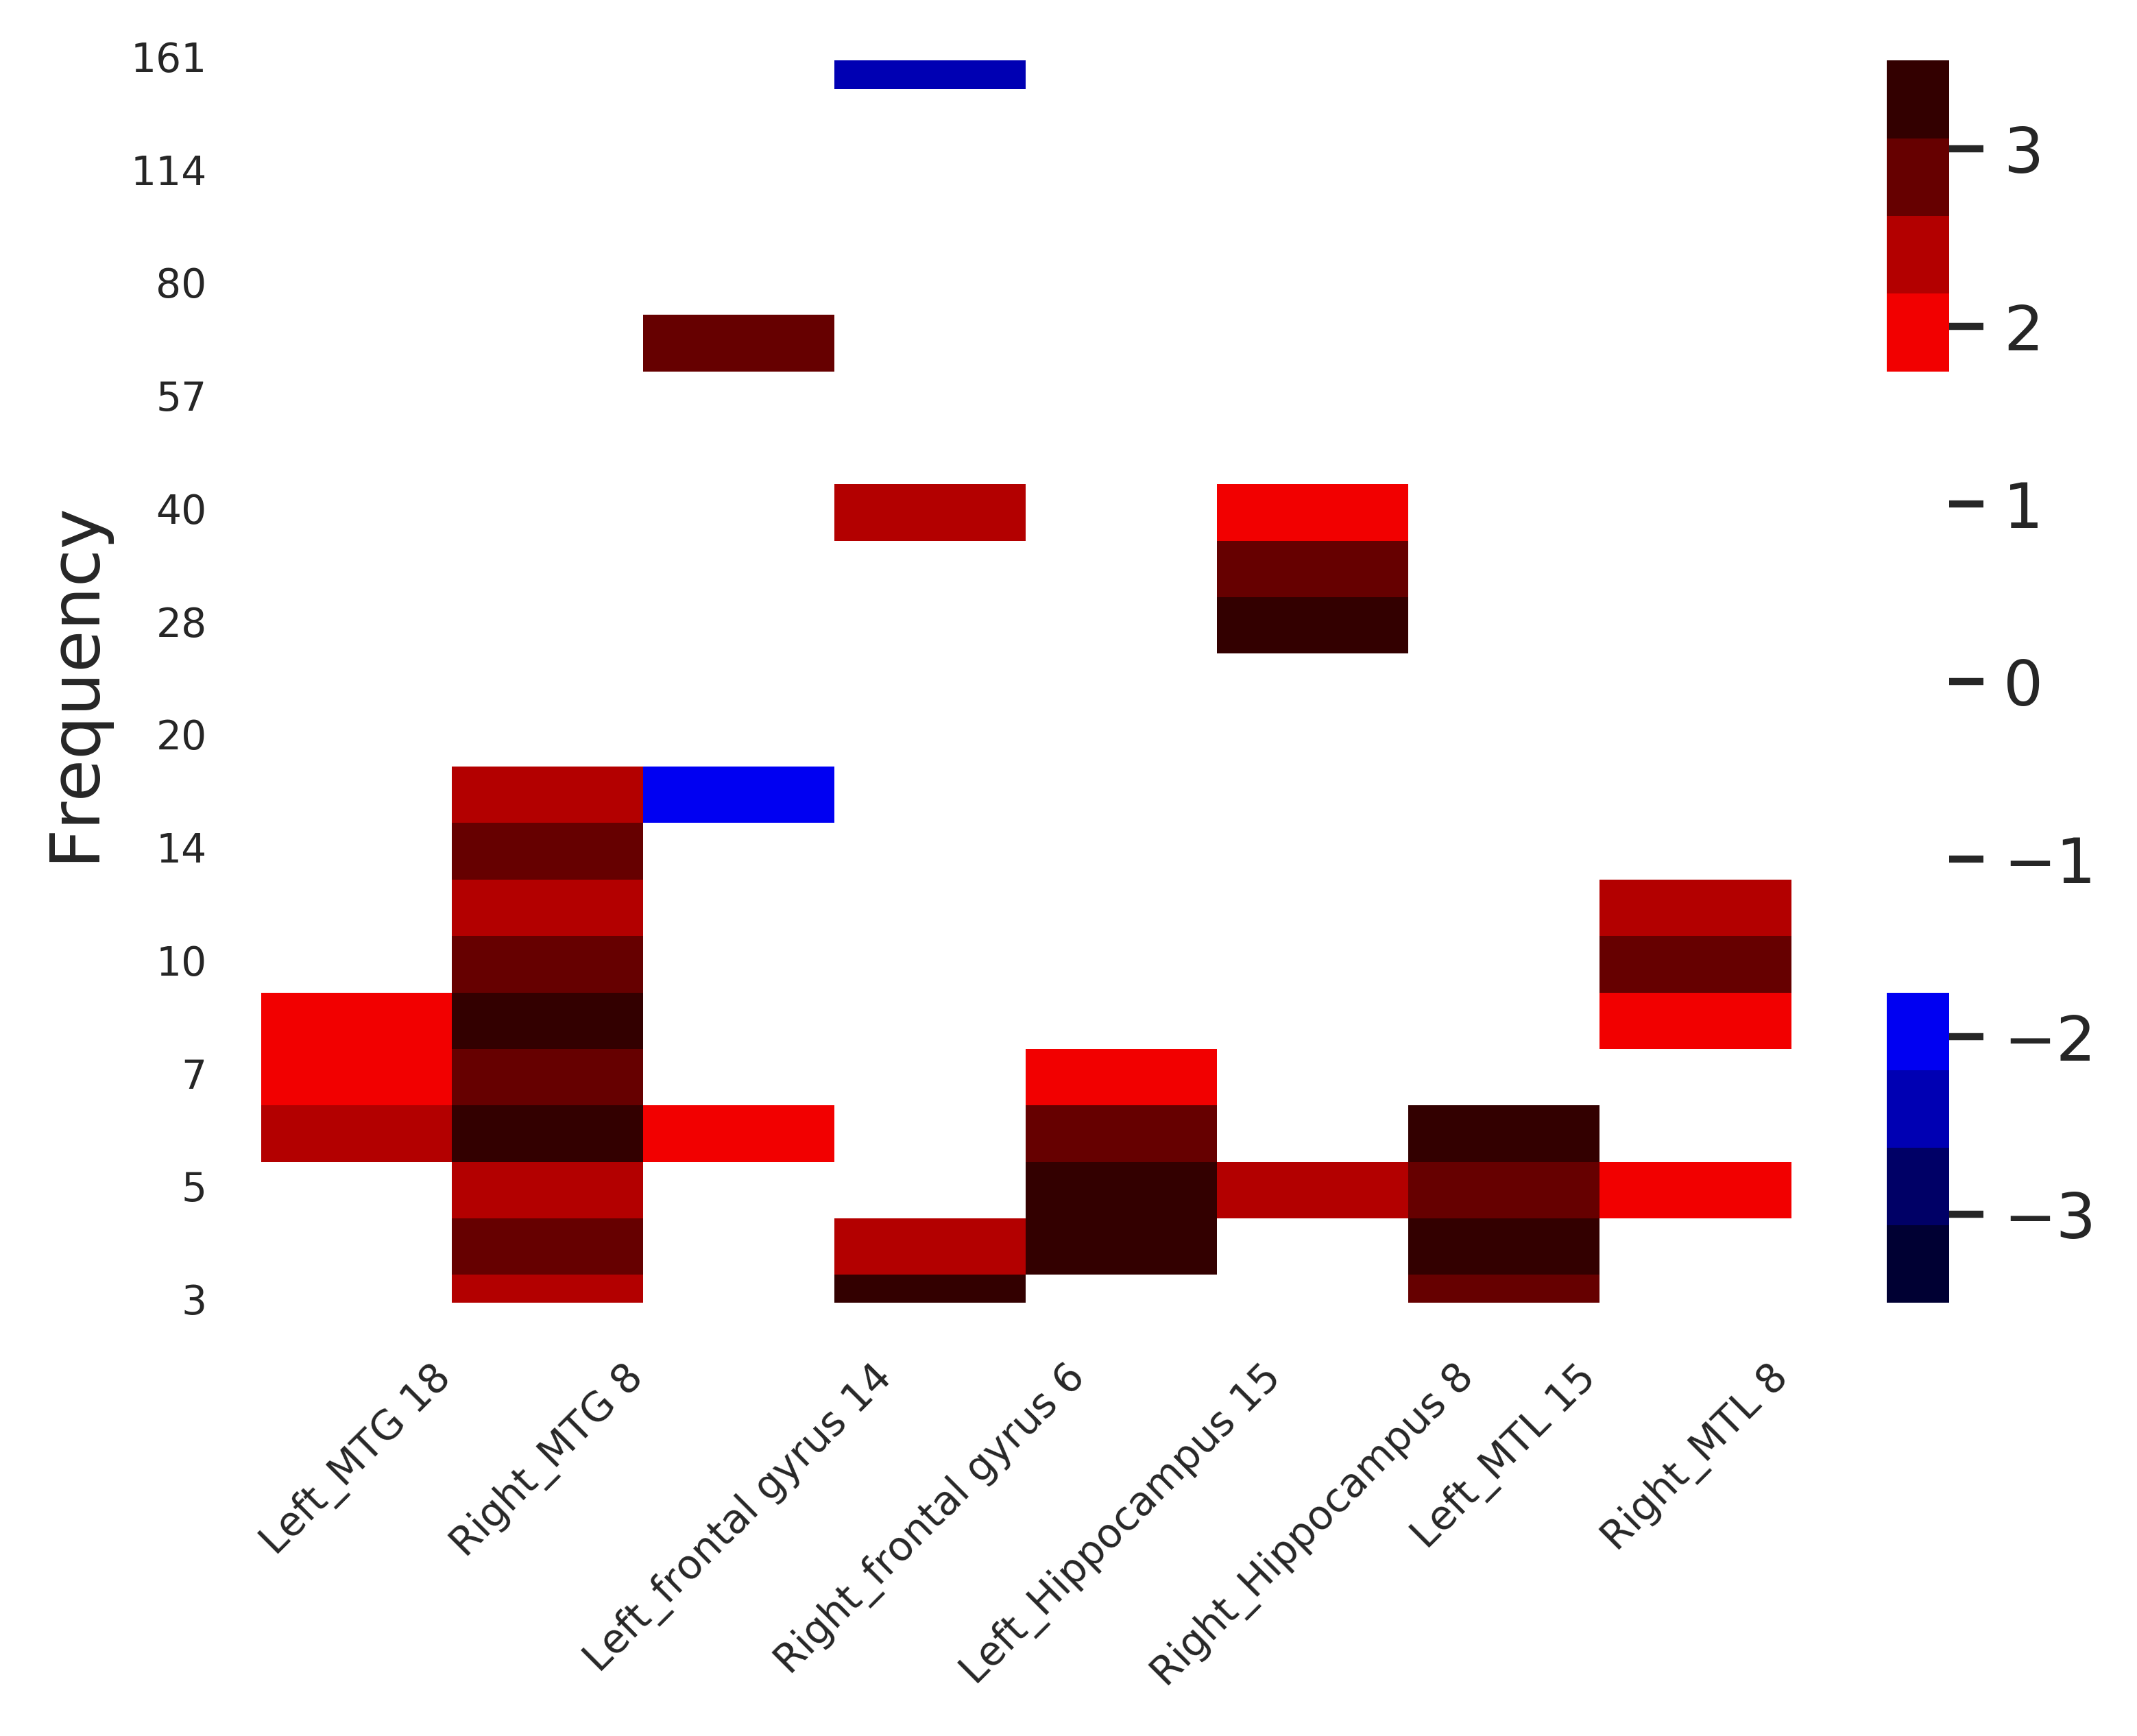

In [14]:
from matplotlib.colors import LinearSegmentedColormap

figsize = [6, 4]
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
vmin = -3.5
vmax = +3.5

# plt.yticks(locs, label = str(freqs))
myColors = ((0.0, 0.0, 0.6, 1.0),(0.0, 0.0, 0.8, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.8, 0.0, 0.0, 1.0),(0.6, 0.0, 0.0, 1.0))
two_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

myColors = ((0.0, 0.0, 0.2, 1.0),(0.0, 0.0, 0.4, 1.0),(0.0, 0.0, 0.7, 1.0), (0.0, 0.0, 0.95, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(1.0, 1.0, 1.0, 1.0),(0.95, 0.0, 0.0, 1.0),(0.7, 0.0, 0.0, 1.0),(0.4, 0.0, 0.0, 1.0),(0.2, 0.0, 0.0, 1.0))
point_five_cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.heatmap(data= all_dat, cmap=point_five_cmap, vmin=vmin, vmax=vmax, ax=_ax)
sns.set(rc = {'figure.figsize':(4,4)})
_ax.invert_yaxis()
locs, labels = plt.yticks()
_ = _ax.set_yticks(locs)
_ = _ax.set_yticklabels(freqs[1::2].astype(int), fontsize = 7, rotation=0)
_ = _ax.set_xticklabels(best_regions, fontsize = 7, rotation = 45)
_ = _ax.set_ylabel('Frequency')

# plot_time_freq(ttest[:,450:750], rel_start = rel_start, rel_stop = rel_stop, freqs = freqs,
#               _ax = _ax, title = "vocalization time-course")

In [33]:
import cmlreaders as cml
import scipy.stats as stats
dpi = 600
freqs = np.logspace(np.log10(3),np.log10(180), 24)
rel_start = 450
rel_stop = 750
print((rel_stop - rel_start) * sr)
wave_number = 5
half_wav = ((1000 / freqs.min()) * wave_number) * 0.5
index = cml.get_data_index('r1')
index = index[index == 'RepFR1']
dat_check = False
all_dat = []
for subj in ['R1584J', 'R1587J', 'R1590T']: 
    sess = 1
    r = cml.CMLReader(subject=subj, experiment='RepFR1', session=sess)
    eeg = r.load('eeg')
    sr = float(eeg.samplerate)
    buffer_ms = (wave_number * (1000/freqs[0])) / 2
    buffer_samp = int(np.ceil(buffer_ms * (sr/1000.)))
    buffer_minimized = buffer_ms/1000
    path = '/scratch/radrogue/RepFR/{}/sme_pow_debug/'.format(subj)
    file_name = '{}_{}_sme_tscore.npy'.format(subj, "first")
#     if dat_check:
#         dat = np.append(dat, np.mean(np.load(path+file_name),0))
#     else:
    dat = np.mean(np.load(path+file_name), 0)
    all_dat.append(dat)
    dat_check = True
    
    plt.close()
all_dat = np.asarray(all_dat)

ttest = stats.ttest_1samp(all_dat, popmean = 0, axis = 0).statistic

avg_data = np.mean(ttest, -1).reshape(24, 1)

figsize = [6, 4]
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]

plot_time_freq(ttest[:,450:750], rel_start = rel_start, rel_stop = rel_stop, freqs = freqs,
              _ax = _ax, title = "vocalization time-course")
plt.show()

614.8217636022514


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/radrogue/RepFR/R1584J/sme_pow_debug/R1584J_first_sme_tscore.npy'

In [82]:
(ttest[:,450:750])

array([[-9.8244986e-03, -8.7132556e-03, -8.8806069e-03, ...,
         5.9327877e-01,  5.8332151e-01,  5.7308084e-01],
       [-1.2996094e-01, -1.3106188e-01, -1.2956092e-01, ...,
         1.1533138e-03, -2.1441763e-03, -8.0163470e-03],
       [ 5.3051412e-03,  5.0727315e-03,  5.0059119e-03, ...,
        -1.0321971e+00, -1.0374045e+00, -1.0258961e+00],
       ...,
       [ 1.0588351e+00,  1.0372540e+00,  8.7600601e-01, ...,
         2.4659944e+00,  2.2130144e+00,  2.2475345e+00],
       [ 3.2144165e-01,  1.0452203e-01,  1.9637562e-02, ...,
         1.4469365e+00,  1.1853524e+00,  1.3418231e+00],
       [ 1.3916895e-01, -2.8763995e-01, -9.1750294e-01, ...,
         1.6431720e+00,  1.1051110e+00,  5.0598866e-01]], dtype=float32)

In [ ]:
import xarray as xr

In [17]:
for i in all_dat:
    print(np.mean(i, -1).shape)

(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)


In [68]:
xr.DataArray(all_dat[:3], dims = ['subj'])

<xarray.DataArray (dim_0: 3, dim_1: 24, dim_2: 1599)>
array([[[ 0.24491537,  0.24047208,  0.2407445 , ..., -0.17569947,
         -0.17414589, -0.17263775],
        [-0.01494182, -0.01596736, -0.01711657, ..., -0.10987251,
         -0.11251745, -0.11423106],
        [-0.2089756 , -0.20871802, -0.20819752, ..., -0.22858612,
         -0.2285318 , -0.22662887],
        ...,
        [-0.12027373, -0.18201111, -0.19297886, ...,  0.3352246 ,
          0.43176627,  0.44478387],
        [-0.2025613 , -0.27236187, -0.2942375 , ...,  0.2015431 ,
          0.211489  ,  0.24462506],
        [-0.327241  , -0.27533233, -0.18073952, ...,  0.18049707,
          0.10722379,  0.10334451]],

       [[-0.37405732, -0.3753089 , -0.37696278, ..., -0.4210637 ,
         -0.41986406, -0.4184897 ],
        [-0.446458  , -0.4440719 , -0.44174156, ..., -0.7290873 ,
         -0.72527736, -0.721548  ],
        [-0.25981915, -0.256988  , -0.25413552, ..., -0.54490304,
         -0.5484606 , -0.55248076],
...
        [-0.00230002,  0.03287832,  0.07224008, ...,  0.0017211 ,
          0.10360714,  0.13719891],
        [-0.45763037, -0.31125465, -0.1602335 , ...,  0.01726039,
          0.28707618,  0.3675191 ],
        [-0.45784804, -0.4047883 , -0.18178087, ...,  0.35651076,
          0.45568648,  0.5220992 ]],

       [[-0.70229113, -0.69933385, -0.6960091 , ..., -0.11458486,
         -0.11514717, -0.11585242],
        [-0.19494638, -0.19097078, -0.18680072, ...,  0.29136714,
          0.29281014,  0.29362962],
        [ 0.11000116,  0.11216614,  0.114215  , ...,  0.0945633 ,
          0.0958049 ,  0.09694979],
        ...,
        [ 0.3911557 ,  0.37809473,  0.36577827, ..., -0.01316049,
         -0.16307488, -0.35889727],
        [ 0.4773052 ,  0.37848517,  0.26971415, ...,  0.18028283,
          0.10186644,  0.01415121],
        [ 0.6048896 ,  0.44941416,  0.2981143 , ...,  0.58891904,
          0.5753479 ,  0.55723435]]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1, dim_2

In [27]:
dat = np.mean(np.load(path+file_name),0)